In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import ast
pd.set_option('display.max_columns', None)
# results = pd.read_html("experiment_results_001/all_experiments_summary.html")[0]


In [36]:
parameters = [
    'year', 'num_house', 'land_cells',
       'prod_multiplier', 'fishing_discount', 'fallow_period',
       'food_expiration_steps', 'marriage_from', 'marriage_to',
       'bride_price_ratio', 'bride_price', 'land_recovery_rate',
       'land_max_capacity', 'initial_quality', 'exchange_rate',
       'luxury_good_storage', 'storage_ratio_low', 'storage_ratio_high',
       'land_capacity_low', 'max_member', 'excess_food_ratio',
       'trade_back_start', 'lux_per_year', 'land_depreciate_factor',
       'fertility_scaler', 'work_scale', 'luxury_goods_in_village',
       'prob_emigrate', 'farming_counter_max', 'spare_food_enabled',
       'fallow_farming', 'emigrate_enabled', 'trading_enabled'
]


### With multiple results - -

In [37]:
import numpy as np
from sklearn.linear_model import BayesianRidge
import ast

results_list = []

for nr in range(1, 31):
    folder_name = f"experiment_30/experiment_results_00{nr}"
    if len(folder_name) > 36:
        folder_name = folder_name[:34] + str(nr)
    results_list.append(pd.read_html(f'{folder_name}/all_experiments_summary.html')[0])


# List of 12 parameters you're analyzing
target_param_names = [
    'fallow_period','food_expiration_steps','bride_price_ratio', 
    'land_recovery_rate','land_max_capacity', 'max_member', 'lux_per_year', 
    'land_depreciate_factor','spare_food_enabled', 'fallow_farming', 
    'emigrate_enabled', 'trading_enabled'
]

param_change_indices = [0, 0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 9, 10, 11]

X_all = []
delta_ginis_all = []

for results in results_list:
    # Extract Gini values
    results = results.drop([3]) # the dead village
    results = results.reset_index(drop=True)
    results['gini_avg'] = results['Gini Coefficients'].apply(lambda x: ast.literal_eval(x)['avg'])

    baseline_gini = results.loc[0, 'gini_avg']
    baseline_values = results.loc[0, target_param_names].values

    delta_ginis = results['gini_avg'].iloc[1:].values - baseline_gini  # shape (19,)

    param_values = []
    for i, param_idx in enumerate(param_change_indices):
        param_name = target_param_names[param_idx]
        value = results.loc[i + 1, param_name]
        param_values.append(value)
    param_values = np.array(param_values)

    # Construct design matrix
    num_rows = len(param_change_indices)
    num_params = len(target_param_names)
    X = np.zeros((num_rows, num_params))

    for i, idx in enumerate(param_change_indices):
        param_name = target_param_names[idx]
        diff = param_values[i] - baseline_values[idx]
        X[i, idx] = diff

    X_all.append(X)
    delta_ginis_all.append(delta_ginis)

# combine all design matrices and response vectors
X_all = np.vstack(X_all)
delta_ginis_all = np.concatenate(delta_ginis_all)

# Fit Bayesian Ridge
model = BayesianRidge()
model.fit(X_all, delta_ginis_all)

coefs = model.coef_
stds = np.sqrt(np.diag(model.sigma_))

print(f"{'Parameter':25s} | {'Coef':>8s} | {'±1.96*STD':>10s} | {'95% Credible Interval':>25s}")
print("-" * 75)
for name, coef, std in zip(target_param_names, coefs, stds):
    ci_low = coef - 1.96 * std
    ci_high = coef + 1.96 * std
    print(f"{name:25s} | {coef:+8.4f} | {1.96*std:10.4f} | [{ci_low:+7.4f}, {ci_high:+7.4f}]")

Parameter                 |     Coef |  ±1.96*STD |     95% Credible Interval
---------------------------------------------------------------------------
fallow_period             |  +0.0004 |     0.0008 | [-0.0005, +0.0012]
food_expiration_steps     |  +0.0020 |     0.0005 | [+0.0015, +0.0026]
bride_price_ratio         |  -0.0666 |     0.0452 | [-0.1118, -0.0215]
land_recovery_rate        |  +0.2163 |     0.0535 | [+0.1628, +0.2697]
land_max_capacity         |  +0.0015 |     0.0003 | [+0.0011, +0.0018]
max_member                |  +0.0089 |     0.0007 | [+0.0082, +0.0096]
lux_per_year              |  +0.0039 |     0.0011 | [+0.0028, +0.0050]
land_depreciate_factor    |  +0.1810 |     0.0535 | [+0.1275, +0.2345]
spare_food_enabled        |  -0.0904 |     0.0231 | [-0.1134, -0.0673]
fallow_farming            |  -0.0879 |     0.0231 | [-0.1110, -0.0649]
emigrate_enabled          |  -0.0994 |     0.0231 | [-0.1224, -0.0763]
trading_enabled           |  +0.0738 |     0.0231 | [+0.0508, +0.

In [30]:
# import numpy as np
# from sklearn.linear_model import BayesianRidge
# import ast

# results_list = []

# for nr in range(1, 3):
#     folder_name = f"re/result_00{nr}"
#     if len(folder_name) > 36:
#         folder_name = folder_name[:34] + str(nr)
#     results_list.append(pd.read_html(f'{folder_name}/all_experiments_summary.html')[0])


# # List of 12 parameters you're analyzing
# target_param_names = ['fallow_period',
#  'food_expiration_steps',
#  'bride_price_ratio',
#  'land_recovery_rate',
#  'land_max_capacity',
#  'max_member',
#  'lux_per_year',
#  'land_depreciate_factor',
#  'spare_food_enabled',
#  'fallow_farming',
#  'emigrate_enabled',
#  'trading_enabled']

# param_change_indices = [0, 0]

# X_all = []
# delta_ginis_all = []

# for results in results_list:
#     # Extract Gini values
#     results = results.reset_index(drop=True)
#     results['gini_avg'] = results['Gini Coefficients'].apply(lambda x: ast.literal_eval(x)['avg'])
#     delta_ginis = results['gini_avg'].iloc[1:].values

#     param_values = []
#     for i, param_idx in enumerate(param_change_indices):
#         param_name = target_param_names[param_idx]
#         value = results.loc[i, param_name]
#         param_values.append(value)
#     param_values = np.array(param_values)

#     # Construct design matrix
#     num_rows = len(param_change_indices)
#     num_params = len(target_param_names)
#     X = np.zeros((num_rows, num_params))

#     for i, idx in enumerate(param_change_indices):
#         param_name = target_param_names[idx]
#         diff = param_values[i]
#         X[i, idx] = diff
#         delta_ginis = results['gini_avg'].iloc[i]
#         delta_ginis_all.append([delta_ginis])

#     X_all.append(X)
    
# # combine all design matrices and response vectors
# X_all = np.vstack(X_all)
# delta_ginis_all = np.concatenate(delta_ginis_all)

# # Fit Bayesian Ridge
# model = BayesianRidge()
# model.fit(X_all, delta_ginis_all)

# coefs = model.coef_
# stds = np.sqrt(np.diag(model.sigma_))

# print(f"{'Parameter':25s} | {'Coef':>8s} | {'±1.96*STD':>10s} | {'95% Credible Interval':>25s}")
# print("-" * 75)
# for name, coef, std in zip(target_param_names, coefs, stds):
#     ci_low = coef - 1.96 * std
#     ci_high = coef + 1.96 * std
#     print(f"{name:25s} | {coef:+8.4f} | {1.96*std:10.4f} | [{ci_low:+7.4f}, {ci_high:+7.4f}]")


# df = pd.DataFrame({
#     'Group': [x for x in X_all.flatten()],
#     'Gini': delta_ginis_all
# })

# # Create box plot
# plt.figure(figsize=(6, 5))
# boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
# medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')


# group_values = df['Group'].dropna().unique()
# group_values = sorted(group_values)
# gini_groups = [df[df['Group'] == val]['Gini'] for val in group_values]
# boxprops = dict(facecolor='lightblue', edgecolor='black')
# medianprops = dict(color='red', linewidth=2)

# Create boxplot
# bp = plt.boxplot(gini_groups,
#                  labels=[str(val) for val in group_values],
#                  patch_artist=True,
#                  boxprops=boxprops,
#                  medianprops=medianprops,
#                  whiskerprops=dict(linewidth=2),
#                  capprops=dict(linewidth=2))



# # Set box colors
# colors = ['lightblue', 'lightgreen']
# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)

# # Add data points
# for i, group in enumerate([True, False]):
#     y = df[df['Group'] == group]['Gini']
#     x = np.random.normal(i+1, 0.02, size=len(y))  # Add slight jitter
#     plt.plot(x, y, 'o', color='darkorange', alpha=0.6, markersize=8)

# # Add labels and title
# plt.title('Gini Coefficient Distribution by Group', fontsize=14, pad=20)
# plt.ylabel('Gini Coefficient', fontsize=12)
# plt.xlabel('Group', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.4)

# # Add horizontal line at overall median
# plt.axhline(y=df['Gini'].median(), color='gray', linestyle=':', linewidth=1.5)

# plt.tight_layout()
# plt.show()

In [38]:
target_param_names = ['fallow_period',
 'food_expiration_steps',
 'bride_price_ratio',
 'land_recovery_rate',
 'land_max_capacity',
 'max_member',
 'lux_per_year',
 'land_depreciate_factor',
 'spare_food_enabled',
 'fallow_farming',
 'emigrate_enabled',
 'trading_enabled']

check = pd.DataFrame(columns=target_param_names, data=X_all)
check['gini'] = delta_ginis_all

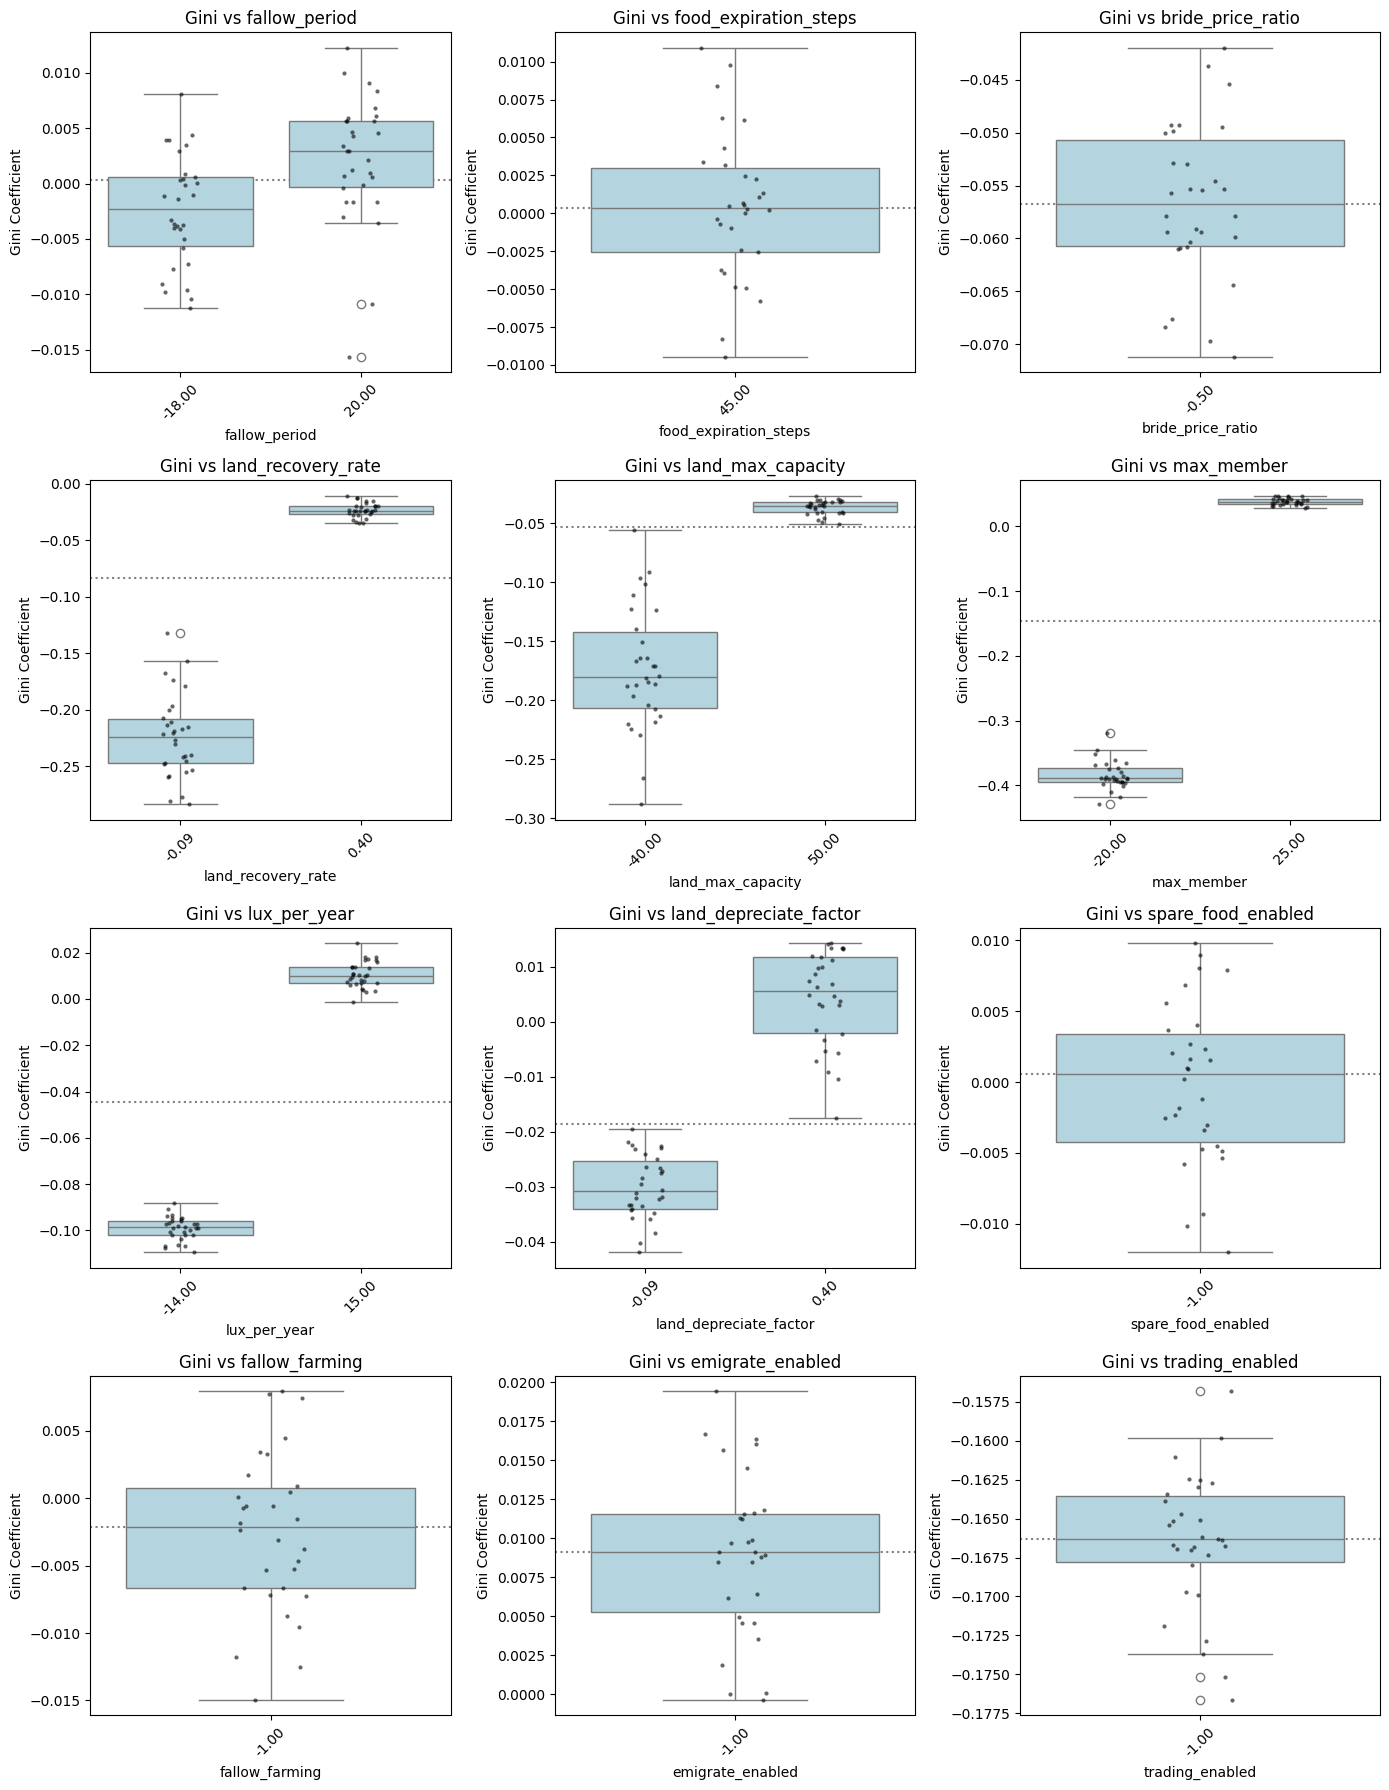

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is named 'check'
parameters = ['fallow_period', 'food_expiration_steps', 'bride_price_ratio', 
              'land_recovery_rate', 'land_max_capacity', 'max_member',
              'lux_per_year', 'land_depreciate_factor', 'spare_food_enabled',
              'fallow_farming', 'emigrate_enabled', 'trading_enabled']

plt.figure(figsize=(14, 18))
for i, param in enumerate(parameters, 1):
    plt.subplot(4, 3, i)

    # Filter rows where the parameter is not zero
    plot_data = check[check[param] != 0][[param, 'gini']].copy()

    # Convert parameter values to strings (categorical) for grouping
    plot_data[param] = plot_data[param].apply(lambda x: f"{x:.2f}")

    # Horizontal reference line at median Gini
    plt.axhline(y=plot_data['gini'].median(), color='gray', linestyle=':', linewidth=1.5)

    # Boxplot
    sns.boxplot(x=param, y='gini', data=plot_data, color='lightblue')

    # Data points (with jitter to avoid overlap)
    sns.stripplot(x=param, y='gini', data=plot_data, 
                  color='black', size=3, jitter=True, alpha=0.6)

    plt.title(f'Gini vs {param}')
    plt.ylabel('Gini Coefficient')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge

# 1. Prepare Data from 'check' DataFrame
X = check.drop(columns=['gini'])  # All columns except 'gini' are features
y = check['gini']  # Target variable

# Convert all features to numeric (safe conversion)
X = X.apply(pd.to_numeric, errors='coerce')

# Remove rows with missing values
valid_rows = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_rows]
y = y[valid_rows]

# 2. Fit Bayesian Ridge Regression
model = BayesianRidge(compute_score=True)
model.fit(X, y)

# 3. Extract results
coefs = model.coef_
stds = np.sqrt(np.diag(model.sigma_))
param_names = X.columns.tolist()

# 4. Display results
print("\n" + "="*80)
print("BAYESIAN RIDGE REGRESSION RESULTS".center(80))
print("="*80)
print(f"{'Parameter':<25s} | {'Coef':>8s} | {'±1.96*STD':>10s} | {'95% CI':>25s} | {'Sig.':>5s}")
print("-"*80)

for name, coef, std in zip(param_names, coefs, stds):
    ci_width = 1.96 * std
    ci_low = coef - ci_width
    ci_high = coef + ci_width
    significant = "YES" if (ci_low * ci_high) > 0 else "NO"
    
    print(f"{name:<25s} | {coef:>+8.4f} | {ci_width:>10.4f} | [{ci_low:>+7.4f}, {ci_high:>+7.4f}] | {significant:^5s}")

# 5. Model diagnostics
print("\n" + "MODEL DIAGNOSTICS".center(80))
print("-"*80)
print(f"{'R² Score:':<20}{model.score(X, y):.4f}")
print(f"{'Alpha (precision):':<20}{model.alpha_:.4f}")
print(f"{'Lambda (reg):':<20}{model.lambda_:.4f}")
print(f"{'Features:':<20}{len(param_names)}")
print(f"{'Samples:':<20}{len(y)}")
print("="*80)


                       BAYESIAN RIDGE REGRESSION RESULTS                        
Parameter                 |     Coef |  ±1.96*STD |                    95% CI |  Sig.
--------------------------------------------------------------------------------
fallow_period             |  +0.0004 |     0.0008 | [-0.0005, +0.0012] |  NO  
food_expiration_steps     |  +0.0020 |     0.0005 | [+0.0015, +0.0026] |  YES 
bride_price_ratio         |  -0.0666 |     0.0452 | [-0.1118, -0.0215] |  YES 
land_recovery_rate        |  +0.2163 |     0.0535 | [+0.1628, +0.2697] |  YES 
land_max_capacity         |  +0.0015 |     0.0003 | [+0.0011, +0.0018] |  YES 
max_member                |  +0.0089 |     0.0007 | [+0.0082, +0.0096] |  YES 
lux_per_year              |  +0.0039 |     0.0011 | [+0.0028, +0.0050] |  YES 
land_depreciate_factor    |  +0.1810 |     0.0535 | [+0.1275, +0.2345] |  YES 
spare_food_enabled        |  -0.0904 |     0.0231 | [-0.1134, -0.0673] |  YES 
fallow_farming            |  -0.0879 |  

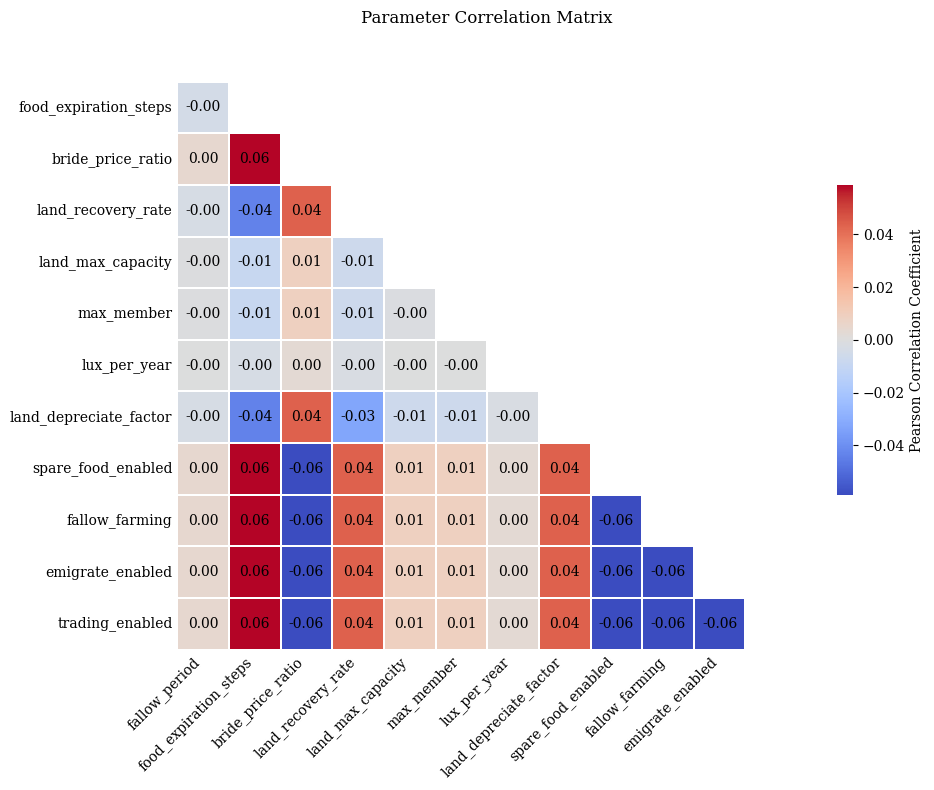

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})
corr = check.drop(columns='gini').corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=0)
lower_triangle = corr.where(~mask)
non_nan_vals = lower_triangle.unstack().dropna()
min_corr = non_nan_vals.min()
max_corr = non_nan_vals.max()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    annot_kws={"color": "black"},
    vmin=min_corr,
    vmax=max_corr,
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.5, "label": "Pearson Correlation Coefficient"}
)

# Get current labels and process them
x_labels = [label.get_text().replace("-", "") for label in ax.get_xticklabels()]
y_labels = [label.get_text().replace("-", "") for label in ax.get_yticklabels()]

# Remove first y-label and last x-label
y_labels[0] = ""  # First y-label (topmost)
x_labels[-1] = ""  # Last x-label (rightmost)

# Apply modified labels
ax.set_xticklabels(
    x_labels, 
    rotation=45, 
    ha='right',
    fontsize=10
)
ax.set_yticklabels(
    y_labels, 
    rotation=0,
    fontsize=10
)
ax.tick_params(axis='both', which='both', length=0)  # Removes all tick marks
plt.title("Parameter Correlation Matrix", pad=5)
plt.tight_layout()
plt.show()

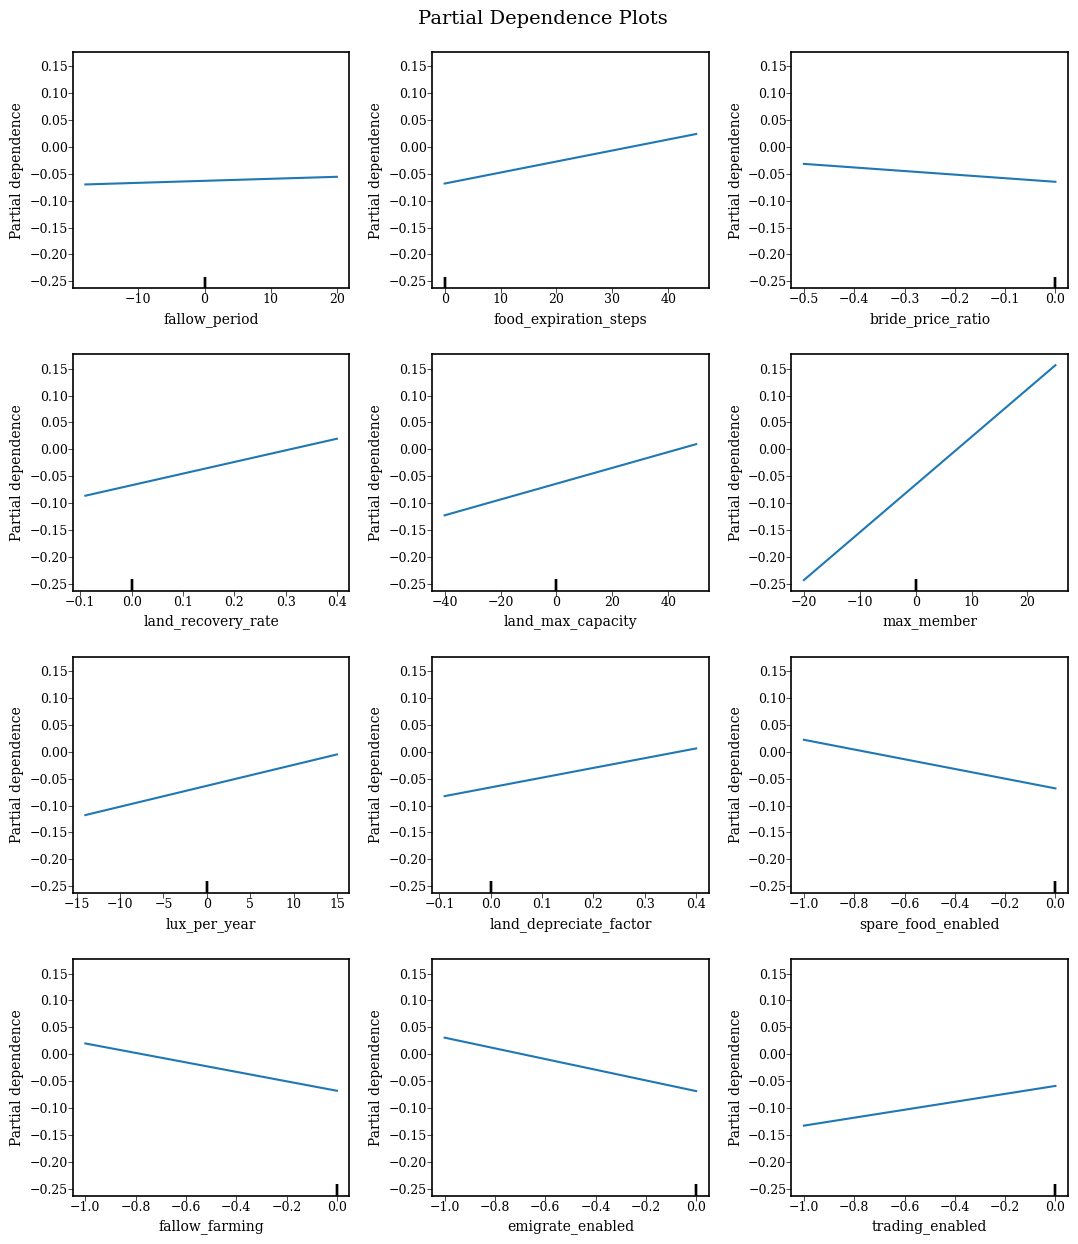

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge
from sklearn.inspection import PartialDependenceDisplay

# Load your DataFrame
# df = pd.read_csv("your_data.csv")  # if you're loading from a file

# Define X and y
X = check.drop(columns='gini')
y = check['gini']

# Fit Bayesian Ridge Regression
model = BayesianRidge(compute_score=True)
model.fit(X, y)

# Optional: Check model performance
# print("R²:", model.score(X, y))

# Generate Partial Dependence Plots
target_param_names = ['fallow_period',
 'food_expiration_steps',
 'bride_price_ratio',
 'land_recovery_rate',
 'land_max_capacity',
 'max_member',
 'lux_per_year',
 'land_depreciate_factor',
 'spare_food_enabled',
 'fallow_farming',
 'emigrate_enabled',
 'trading_enabled']


import math

# Layout configuration
n_features = len(target_param_names)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)
width_per_plot = 3.5
height_per_plot = 3

plt.rcParams.update({
    'axes.titlesize': 12,    # Subplot title size (originally 10)
    'axes.labelsize': 10,    # Axis label size (originally 8)
    'xtick.labelsize': 9,    # X-tick size (originally 7)
    'ytick.labelsize': 9,    # Y-tick size (originally 7)
    'figure.titlesize': 14   # Main title size (originally 12)
})

# Create figure
fig, ax = plt.subplots(n_rows, n_cols, 
                      figsize=(width_per_plot * n_cols, height_per_plot * n_rows))
ax = ax.flatten()

# Create PDPs
display = PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=target_param_names,
    ax=ax,
    line_kw={'linewidth': 1.5}
)

# Adjust box thickness for each subplot
for i, a in enumerate(ax):
    if i >= n_features:
        a.axis('off')
        continue
    
    # Set spine (box) linewidth - adjust this value as needed
    for spine in ['top', 'bottom', 'left', 'right']:
        a.spines[spine].set_linewidth(1.2)  # Thinner than default (1.0)
        # a.spines[spine].set_linewidth(2.0)  # Thicker than default


    # Other formatting (keep your existing settings)
    a.title.set_size(9)
    a.tick_params(axis='both', which='major', labelsize=9, pad=0, width=0.5)

fig.suptitle("Partial Dependence Plots", y=1.02)
plt.tight_layout(pad=0, w_pad=2.0, h_pad=2.0)
plt.show()

### Visulizations

In [45]:
import pandas as pd
import numpy as np

import ternary
import ast
import os
from scipy.interpolate import Rbf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# [Previous data loading and processing code remains the same until the plotting section]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ternary
import ast
import os
from scipy.interpolate import Rbf

matplotlib.rcParams.update({'text.usetex': False,
                            'text.latex.preamble': r"\usepackage{amsmath}\usepackage{siunitx}\usepackage{textcomp}\usepackage{gensymb}"})

# Change font size and style
matplotlib.rcParams.update({'font.size': 18, 'font.style': 'normal', 'font.family':'serif'})


# Load and process data
folder_names = [f"experiment_30/experiment_results_00{i}" for i in range(1, 31)]
all_data = []

for folder in folder_names:
    html_path = os.path.join(folder, "all_experiments_summary.html")
    if os.path.exists(html_path):
        df = pd.read_html(html_path)[0]
        df = df.drop([3], errors='ignore')
        df['gini'] = df['Gini Coefficients'].apply(lambda x: ast.literal_eval(x)['avg'])
        all_data.append(df)
        # print(folder)

if not all_data:
    raise ValueError("No valid data found in any input folder")

df_all = pd.concat(all_data, ignore_index=True)

# Parameters and normalization
# params = ['bride_price_ratio', 'max_member', 'emigrate_enabled']
params = ['land_recovery_rate', 'land_depreciate_factor', 'land_max_capacity']
df_all['spare_food_enabled'] = df_all['spare_food_enabled'].astype(int) 
df_all['emigrate_enabled'] = df_all['emigrate_enabled'].astype(int) 

# params = ['lux_per_year', 'food_expiration_steps', 'spare_food_enabled']
for i, param in enumerate(params):
    df_all[['a','b','c'][i]] = ((df_all[param] - df_all[param].min()) / 
                              (df_all[param].max() - df_all[param].min()) * 100).round()

# Ensure a + b + c = 100
total = df_all['a'] + df_all['b'] + df_all['c']
df_all['a'] = (df_all['a'] / total * 100).round()
df_all['b'] = (df_all['b'] / total * 100).round()
df_all['c'] = 100 - df_all['a'] - df_all['b']

# Prepare data
gini_data = df_all.groupby(['a','b','c'])['gini'].mean().to_dict()

#  ignore the misleading values
# items = list(gini_data.items())
# del items[3]
# gini_data = dict(items)


points = np.array(list(gini_data.keys()))
values = np.array(list(gini_data.values()))





# Create dense grid for smooth coverage
grid_resolution = 200
a = np.linspace(0, 100, grid_resolution)
b = np.linspace(0, 100, grid_resolution)
A, B = np.meshgrid(a, b)
C = 100 - A - B
grid_points = np.column_stack([A.ravel(), B.ravel(), C.ravel()])
valid_mask = grid_points[:,2] >= 0
grid_points = grid_points[valid_mask]

# Enhanced RBF interpolation with adjusted parameters
rbf = Rbf(points[:,0], points[:,1], points[:,2], values, 
          function='multiquadric',  # Better for sparse data
          smooth=5,  # Increased smoothing
          epsilon=2)  # Shape parameter
grid_values = rbf(grid_points[:,0], grid_points[:,1], grid_points[:,2])

# Clip values to original data range
grid_values = np.clip(grid_values, min(values), max(values))

heatmap_data = {tuple(p.astype(int)): float(v) for p,v in zip(grid_points, grid_values)}


In [46]:
mappable = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=min(values), vmax=max(values)),
    cmap='plasma'
)
plt.figure(figsize=(10, 8))

fig, tax = ternary.figure(scale=100)
fig.patch.set_facecolor('white')

ax = tax.get_axes()
ax.set_position([0.1, 0.1, 0.75, 0.8])

heatmap_obj = tax.heatmap(
    heatmap_data,
    style="hexagonal",
    cmap="plasma",
    vmin=min(values),
    vmax=max(values),
    colorbar=False
)

cbar = plt.colorbar(
    mappable,
    ax=ax,
    shrink=0.8,
    pad=0.05,
    aspect=15
)

cbar.set_label("Gini Coefficient", size=10, labelpad=5)
cbar.ax.tick_params(labelsize=8)

tax._redraw_labels()

# First draw the ticks normally
tax.ticks(axis='lbr', multiple=20, linewidth=1, fontsize=10, offset=0.02)

# Then manually modify the text objects to hide the '0' labels
for text in tax.get_axes().texts:
    if text.get_text() == '0':
        text.set_visible(False)

tax.boundary(linewidth=1.5)
tax.gridlines(multiple=20, color="white", alpha=0.2)
tax.clear_matplotlib_ticks()

tax.set_title("Population Behavior Effect on Gini Coefficient", 
             fontsize=14, pad=5, y=1.05)


tax.left_axis_label("Emigration", offset=0.16, fontsize=10)

tax.right_axis_label("Family Max Member", offset=0.16, fontsize=10)       # Right axis (B)
tax.bottom_axis_label("Bride Price", offset=-0.02, fontsize=10) 

plt.tight_layout(pad=2.0)
plt.show()


<Figure size 1000x800 with 0 Axes>

### Bayesian on Functions

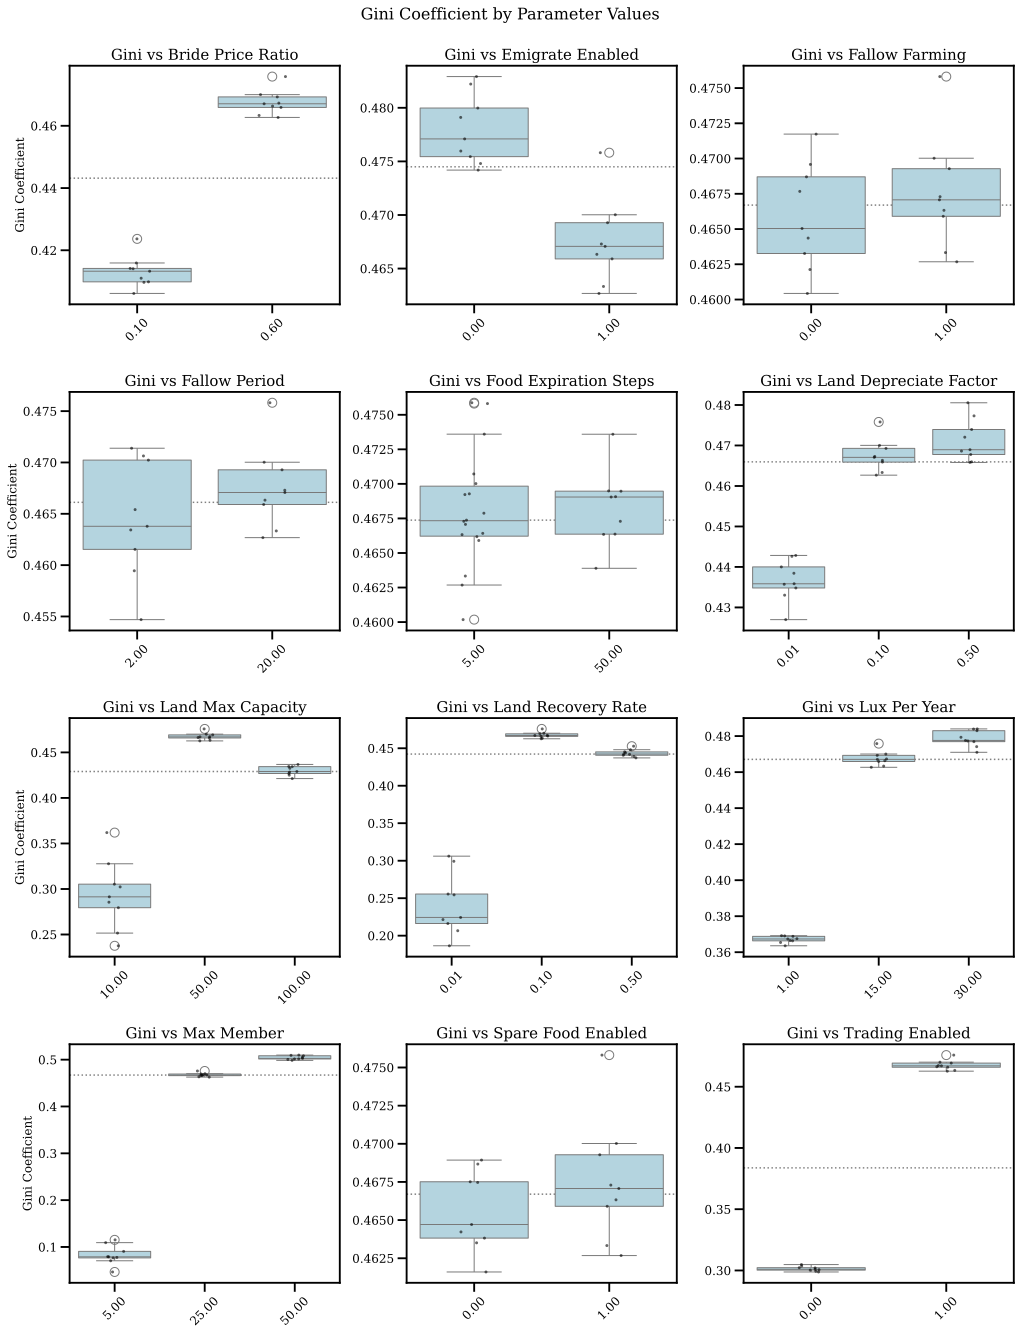

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# plt.style.use('seaborn-whitegrid')
sns.set_context("talk")
plt.rcParams.update({'font.size': 10, 'font.family': 'serif'})
matplotlib.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})


# Load and process data
folder_names = [f"experiment_30/experiment_results_00{i}" for i in range(1, 15)]
all_data = []

for folder in folder_names:
    html_path = os.path.join(folder, "all_experiments_summary.html")
    if os.path.exists(html_path):
        try:
            df = pd.read_html(html_path)[0]
            df = df.drop([3], errors='ignore')
            df['gini'] = df['Gini Coefficients'].apply(lambda x: ast.literal_eval(x)['avg'])
            all_data.append(df)
        except Exception as e:
            print(f"Skipped {folder}: {str(e)}")
            continue

if not all_data:
    raise ValueError("No valid data found in any input folder")

df_all = pd.concat(all_data, ignore_index=True)

# df_all['spare_food_enabled'] = df_all['spare_food_enabled'].astype(int) 
# df_all['emigrate_enabled'] = df_all['emigrate_enabled'].astype(int) 

# List of parameters to track
params = ['land_recovery_rate', 'land_depreciate_factor', 'land_max_capacity',
          'bride_price_ratio', 'max_member', 'lux_per_year', 'food_expiration_steps',
          'spare_food_enabled', 'fallow_farming', 'emigrate_enabled', 'fallow_period', 'trading_enabled']
target_param_names = [
    'fallow_period','food_expiration_steps','bride_price_ratio', 
    'land_recovery_rate','land_max_capacity', 'max_member', 'lux_per_year', 
    'land_depreciate_factor','spare_food_enabled', 'fallow_farming', 
    'emigrate_enabled', 'trading_enabled'
]
param_change_indices = [0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 9, 10, 11]

plot_data = []

block_size = 19  # 1 baseline + 19 experiments
num_blocks = len(df_all) // block_size

for i in range(num_blocks):
# for i in range(1):
    block = df_all.iloc[i * block_size:(i + 1) * block_size].copy()
    baseline = block.iloc[0]  # Always the first row in the block
    block['Experiment ID'] = range(0, len(block))

    for idx, para_nr in enumerate(param_change_indices):
        
        actual_para = target_param_names[para_nr]
        plot_data.append({
            'Parameter': actual_para,
            'Value': block.iloc[idx][actual_para],
            'Gini': block.iloc[idx]['gini']
        })

        plot_data.append({
            'Parameter': actual_para,
            'Value': baseline[actual_para],
            'Gini': baseline['gini']
        })
        # print(idx, para_nr, actual_para, block.iloc[idx][actual_para])
    # print(baseline['gini'])

df_plot = pd.DataFrame(plot_data)
df_plot = df_plot.drop_duplicates()
df_plot = df_plot.sort_values(by="Parameter").reset_index(drop=True)


plt.figure(figsize=(14, 18))
parameters = df_plot['Parameter'].unique()
n_rows = (len(parameters) + 2) // 3  # Calculate rows needed for 3-column layout

for i, param in enumerate(parameters, 1):
    ax = plt.subplot(n_rows, 3, i)
    subset = df_plot[df_plot['Parameter'] == param].copy()
    subset = subset.sort_values('Value')
    subset.loc[:, 'Value'] = subset['Value'].apply(lambda x: f"{x:.2f}")
    
    plt.axhline(y=subset['Gini'].median(), color='gray', linestyle=':', linewidth=1.5)
    sns.boxplot(x='Value', y='Gini', data=subset, color='lightblue')
    sns.stripplot(x='Value', y='Gini', data=subset, 
                 color='black', size=3, jitter=True, alpha=0.6)
    
    # Formatting
    plt.title(f'Gini vs {param.replace("_", " ").title()}', fontsize=15)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Remove all x-axis labels
    ax.set_xlabel('')
    
    # Only show y-label for first subplot in each row
    if (i-1) % 3 != 0:  # If not first column
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Gini Coefficient', fontsize=12)

plt.suptitle("Gini Coefficient by Parameter Values", fontsize=16, y=1.02)
# Adjust spacing (add these parameters)
plt.tight_layout(
    pad=0,          # Padding around figure edges
    w_pad=2.0,        # Horizontal spacing between subplots
    h_pad=2.0         # Vertical spacing between subplots
)

plt.show()

In [ ]:
# df_plot.to_csv("df_plot.csv")